<a href="https://colab.research.google.com/github/EdmersonLow/IE4476-Project/blob/main/IE4476.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import mahalanobis

# 2. Load Dataset

In [ ]:
file_path_train = '/content/drive/My Drive/COMPUTER VISION PROJECT/Dataset/fashion-mnist_train.csv'
file_path_test = '/content/drive/My Drive/COMPUTER VISION PROJECT/Dataset/fashion-mnist_test.csv'
train_data = pd.read_csv(file_path_train)
test_data = pd.read_csv(file_path_test)

In [ ]:
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Define Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import mahalanobis
import numpy as np

def knn_classifier(X_train, X_val, X_test, y_train, y_val, y_test, n_neighbors=5):
    """
    K-Nearest Neighbors (KNN) Classifier.
    """
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    val_acc = accuracy_score(y_val, knn.predict(X_val))
    test_acc = accuracy_score(y_test, knn.predict(X_test))
    return val_acc, test_acc

def mahalanobis_classifier(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Mahalanobis Distance Classifier.
    """
    classes = np.unique(y_train)
    class_means = {c: X_train[y_train == c].mean(axis=0) for c in classes}

    # Compute pooled covariance matrix
    pooled_cov = np.zeros((X_train.shape[1], X_train.shape[1]))
    n_samples = 0

    for c in classes:
        X_c = X_train[y_train == c]
        n_c = len(X_c)
        X_centered = X_c - class_means[c]
        pooled_cov += np.dot(X_centered.T, X_centered)
        n_samples += n_c

    pooled_cov /= (n_samples - len(classes))
    inv_cov = np.linalg.pinv(pooled_cov)  # Use pseudo-inverse for stability

    def predict(X):
        predictions = []
        for x in X:
            distances = {c: mahalanobis(x, class_means[c], inv_cov) for c in classes}
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)

    train_pred = predict(X_train)
    val_pred = predict(X_val)
    test_pred = predict(X_test)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)
    return train_acc, val_acc, test_acc

def linear_svm_classifier(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Linear Support Vector Machine (SVM) Classifier.
    """
    svm = LinearSVC(random_state=42, max_iter=5000, dual=False)
    svm.fit(X_train, y_train)
    val_acc = accuracy_score(y_val, svm.predict(X_val))
    test_acc = accuracy_score(y_test, svm.predict(X_test))
    return val_acc, test_acc


# 3. PCA Analysis

In [ ]:
def pca_analysis(X_train, X_val, X_test, y_train, y_val, y_test):
    components_list = [2, 5, 20, 50, 137, 256, 784]
    results = []

    for n_components in components_list:
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_val_pca = pca.transform(X_val)
        X_test_pca = pca.transform(X_test)

        for classifier_name, classifier_func in [
            ('KNN', knn_classifier),
            ('Mahalanobis', mahalanobis_classifier),
            ('Linear SVM', linear_svm_classifier)
        ]:
            val_acc, test_acc = classifier_func(
                X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test
            )
            results.append({
                'Method': 'PCA',
                'Components': n_components,
                'Classifier': classifier_name,
                'Validation Accuracy': val_acc * 100,
                'Test Accuracy': test_acc * 100
            })
    return pd.DataFrame(results)

# 4. LDA Analysis

In [ ]:
def lda_analysis(X_train, X_val, X_test, y_train, y_val, y_test):
    num_classes = len(np.unique(y_train))
    max_components = min(num_classes - 1, X_train.shape[1])
    components_list = range(1, max_components + 1)
    results = []

    for n_components in components_list:
        lda = LDA(n_components=n_components)
        try:
            X_train_lda = lda.fit_transform(X_train, y_train)
            X_val_lda = lda.transform(X_val)
            X_test_lda = lda.transform(X_test)


            for classifier_name, classifier_func in [
                ('KNN', knn_classifier),
                ('Mahalanobis', mahalanobis_classifier),
                ('Linear SVM', linear_svm_classifier)
            ]:
                val_acc, test_acc = classifier_func(
                    X_train_lda, X_val_lda, X_test_lda, y_train, y_val, y_test
                )
                results.append({
                    'Method': 'LDA',
                    'Components': n_components,
                    'Classifier': classifier_name,
                    'Validation Accuracy': val_acc * 100,
                    'Test Accuracy': test_acc * 100
                })

        except Exception as e:
            print(f"Error during LDA or classification for n_components={n_components}: {e}")

    return pd.DataFrame(results)

# PCA + LDA Analysis

In [ ]:
# 5. PCA + LDA Analysis
def pca_lda_analysis(X_train, X_val, X_test, y_train, y_val, y_test):
    pca_components_list = [100, 137]
    lda_components_list = [3, 9]
    results = []

    for pca_components in pca_components_list:
        for lda_components in lda_components_list:
            pca = PCA(n_components=pca_components)
            X_train_pca = pca.fit_transform(X_train)
            X_val_pca = pca.transform(X_val)
            X_test_pca = pca.transform(X_test)

            lda = LDA(n_components=lda_components)
            X_train_combined = lda.fit_transform(X_train_pca, y_train)
            X_val_combined = lda.transform(X_val_pca)
            X_test_combined = lda.transform(X_test_pca)

            for classifier_name, classifier_func in [
                ('KNN', knn_classifier),
                ('Mahalanobis', mahalanobis_classifier),
                ('Linear SVM', linear_svm_classifier)
            ]:
                val_acc, test_acc = classifier_func(
                    X_train_combined, X_val_combined, X_test_combined, y_train, y_val, y_test
                )
                results.append({
                    'Method': 'PCA+LDA',
                    'Components': f'PCA={pca_components}, LDA={lda_components}',
                    'Classifier': classifier_name,
                    'Validation Accuracy': val_acc * 100,
                    'Test Accuracy': test_acc * 100
                })
    return pd.DataFrame(results)


# 6. Run Analysis

In [ ]:
# 6. Run Analyses
pca_results = pca_analysis(X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

In [ ]:
lda_results = lda_analysis(X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Number of classes: 10
Maximum allowable n_components for LDA: 9
Components list: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Running LDA with n_components=1
Shapes after LDA (n_components=1):
  X_train_lda: (48000, 1), X_val_lda: (12000, 1), X_test_lda: (10000, 1)
Error during LDA or classification for n_components=1: 0-dimensional array given. Array must be at least two-dimensional
Running LDA with n_components=2
Shapes after LDA (n_components=2):
  X_train_lda: (48000, 2), X_val_lda: (12000, 2), X_test_lda: (10000, 2)
Running LDA with n_components=3
Shapes after LDA (n_components=3):
  X_train_lda: (48000, 3), X_val_lda: (12000, 3), X_test_lda: (10000, 3)
Running LDA with n_components=4
Shapes after LDA (n_components=4):
  X_train_lda: (48000, 4), X_val_lda: (12000, 4), X_test_lda: (10000, 4)
Running LDA with n_components=5
Shapes after LDA (n_components=5):
  X_train_lda: (48000, 5), X_val_lda: (12000, 5), X_test_lda: (10000, 5)
Running LDA with n_components=6
Shapes after LDA (n_components=6):
  X

In [ ]:
pca_lda_results = pca_lda_analysis(X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

     Method      Components   Classifier  Validation Accuracy  Test Accuracy
0       PCA               2          KNN            51.116667          50.53
1       PCA               2  Mahalanobis            44.666667          46.16
2       PCA               2   Linear SVM            42.508333          43.01
3       PCA               5          KNN            74.333333          74.15
4       PCA               5  Mahalanobis            59.775000          59.78
5       PCA               5   Linear SVM            64.983333          64.61
6       PCA              20          KNN            83.525000          84.37
7       PCA              20  Mahalanobis            72.616667          73.23
8       PCA              20   Linear SVM            77.816667          78.49
9       PCA              50          KNN            85.466667          85.78
10      PCA              50  Mahalanobis            77.433333          77.67
11      PCA              50   Linear SVM            82.000000          82.41

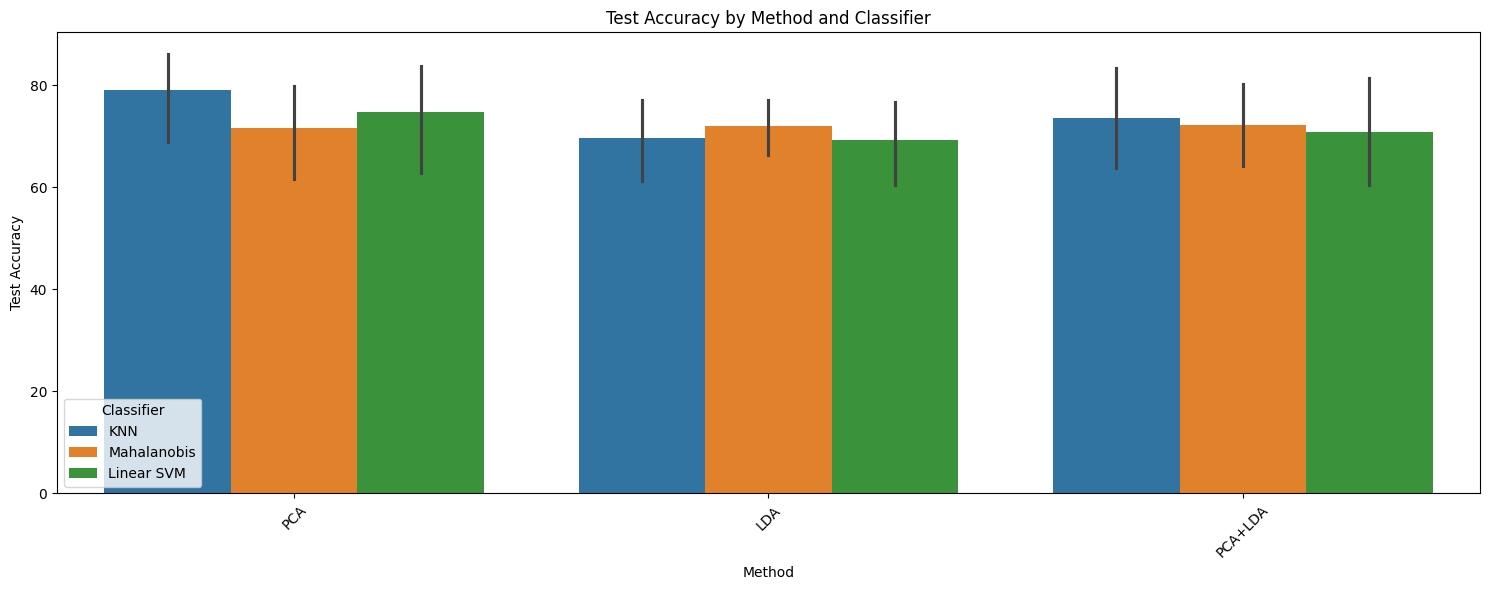

In [ ]:
# Combine all results
all_results = pd.concat([pca_results, lda_results, pca_lda_results], ignore_index=True)

# Save results
all_results.to_csv("combined_analysis_results.csv", index=False)

# Display Results
print(all_results)

# Visualize Results
plt.figure(figsize=(15, 6))
sns.barplot(data=all_results, x='Method', y='Test Accuracy', hue='Classifier')
plt.title('Test Accuracy by Method and Classifier')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Plotting Results

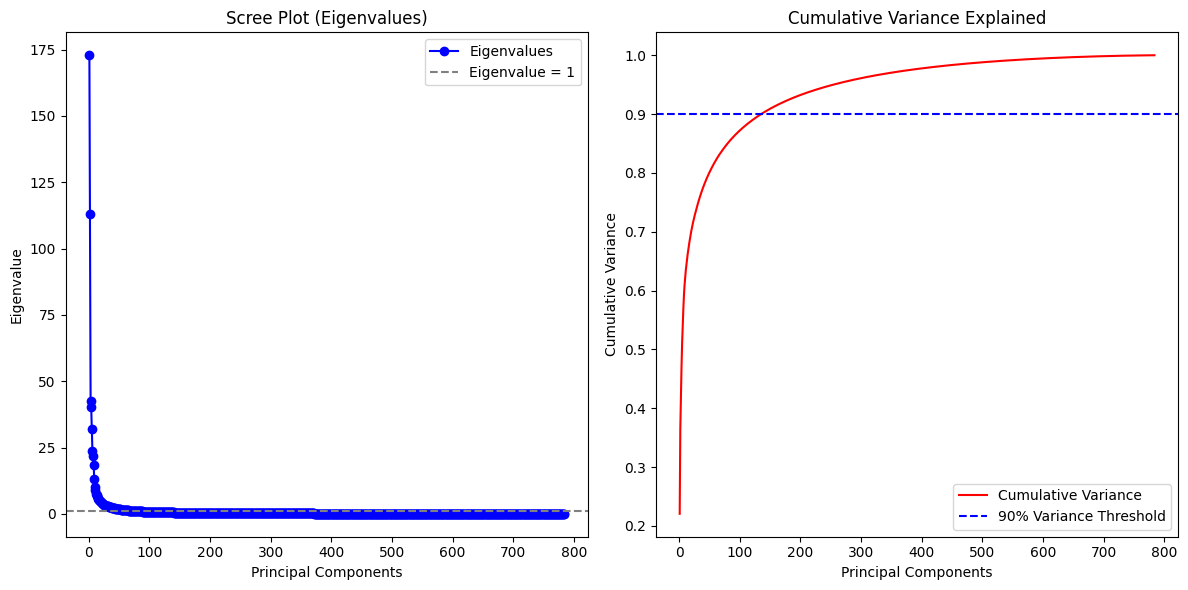

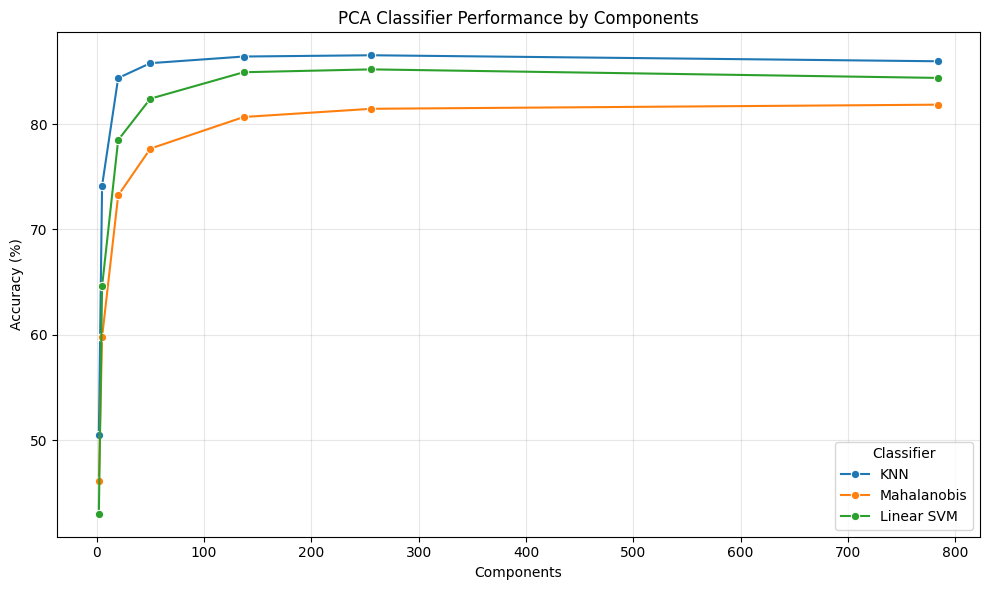

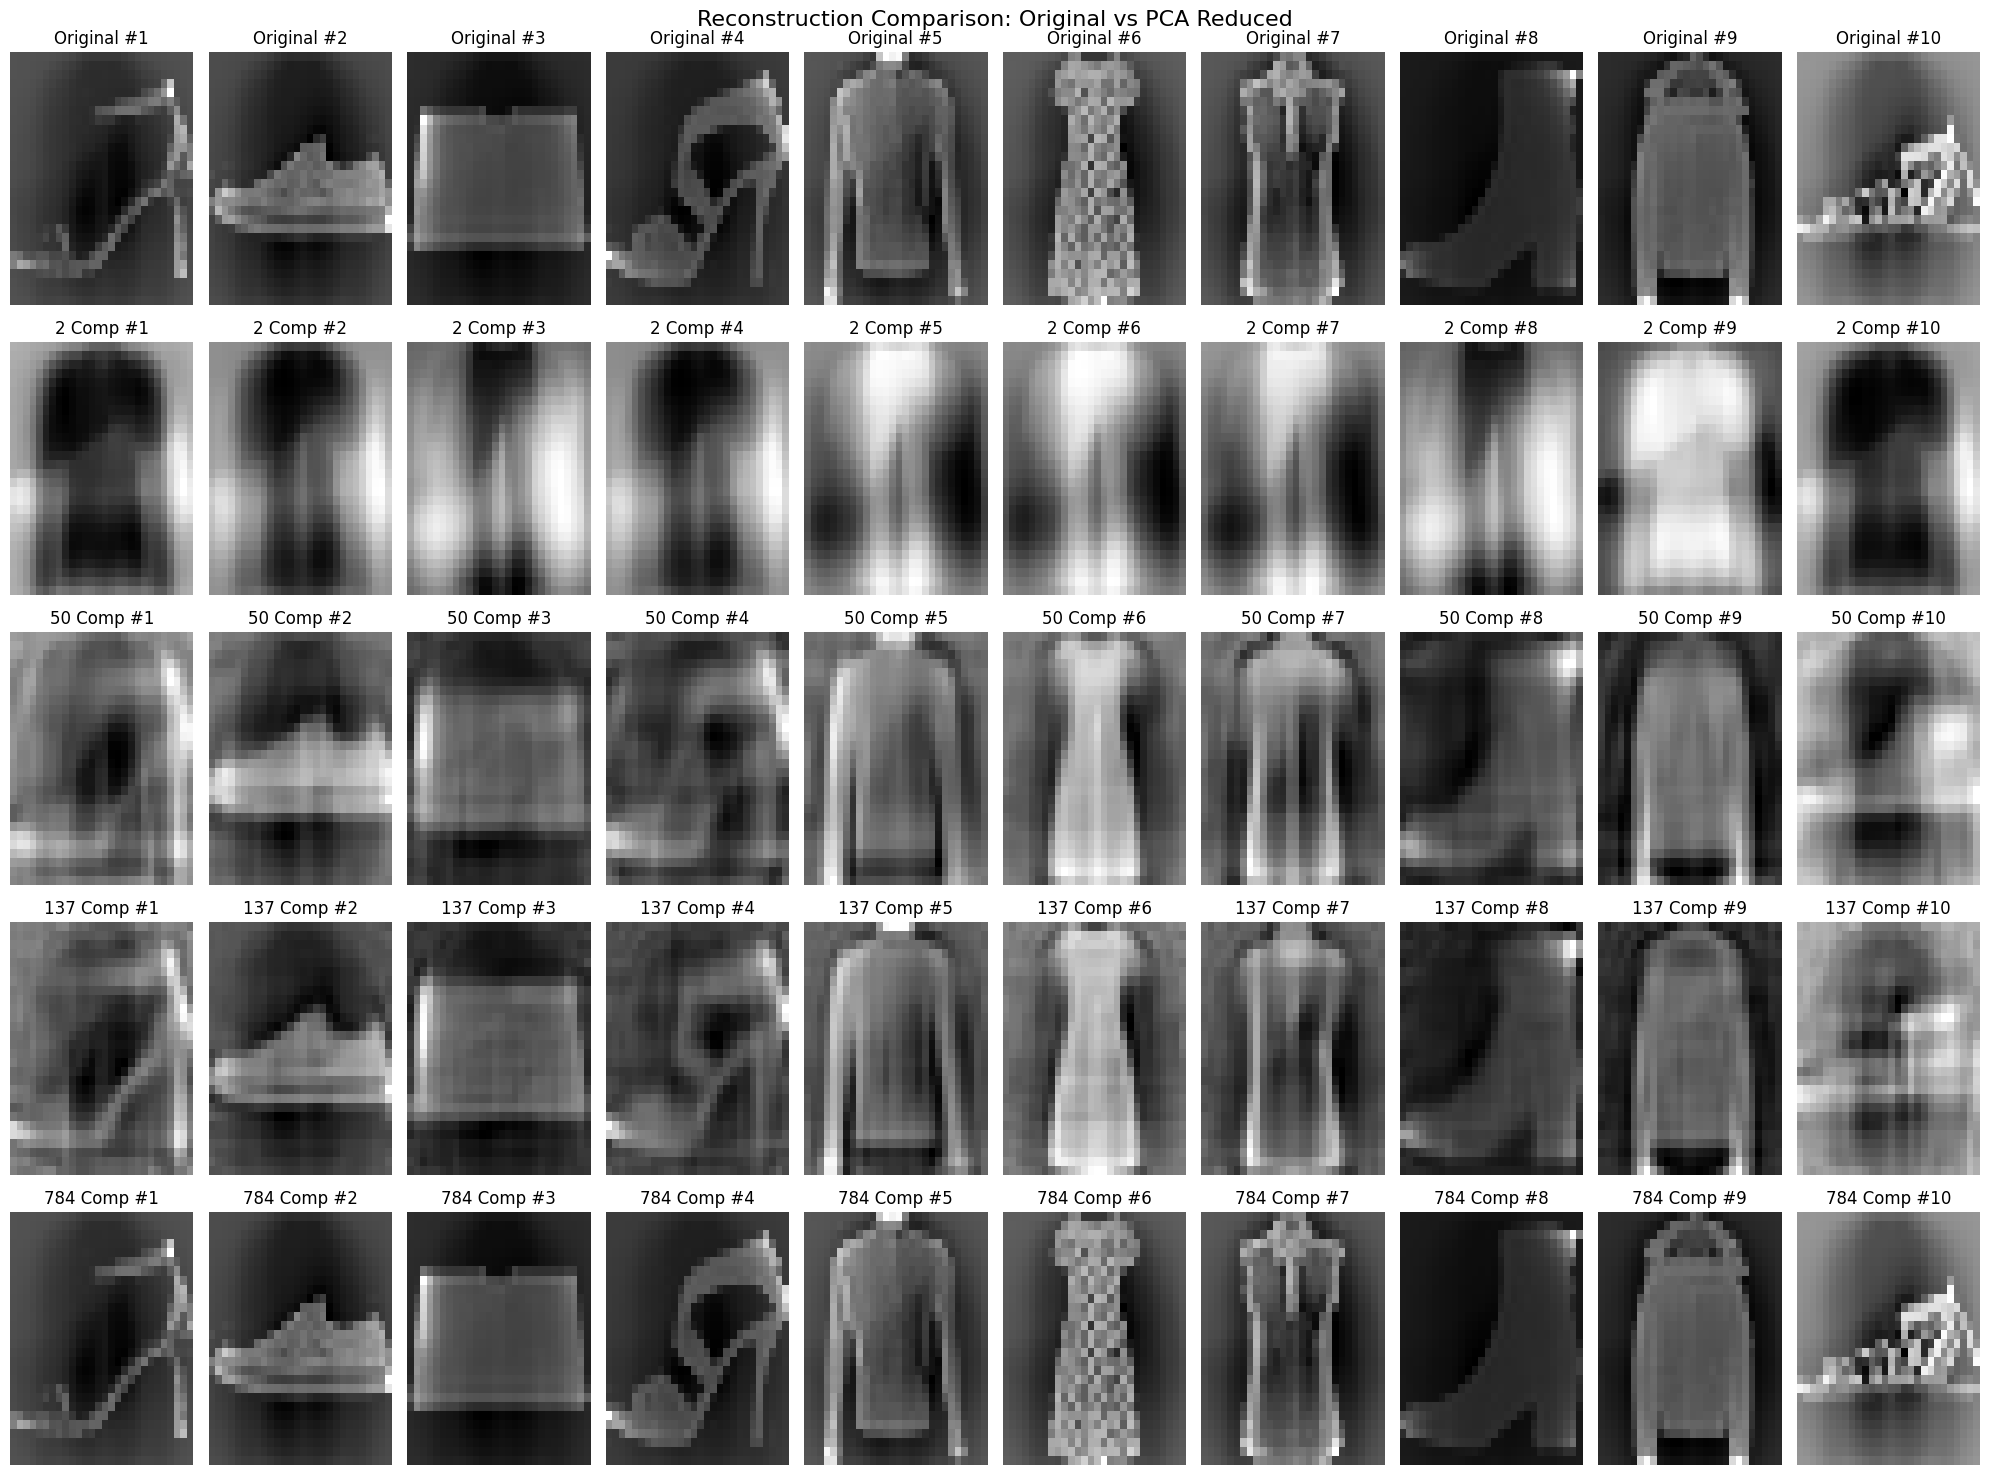

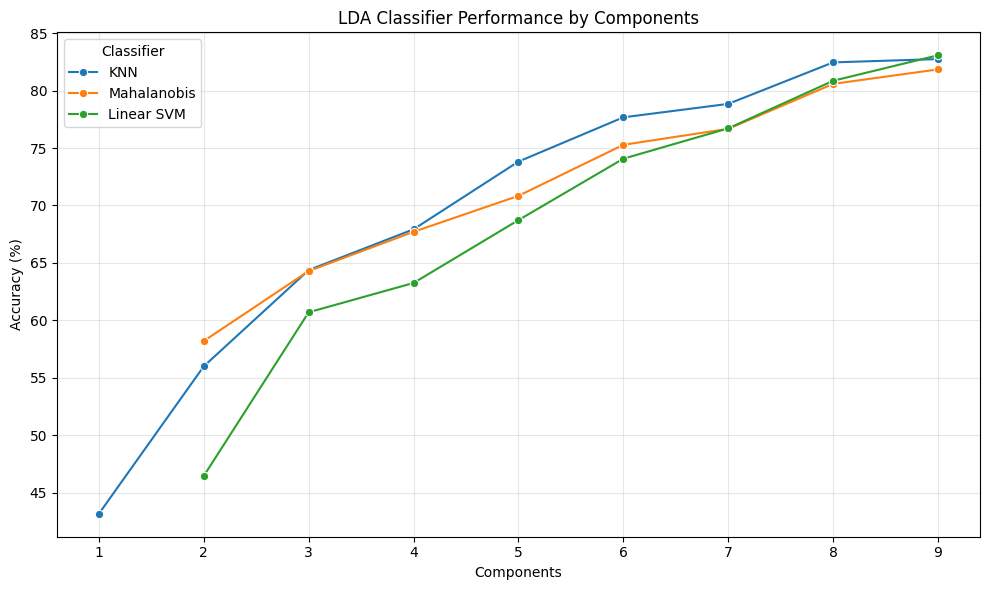

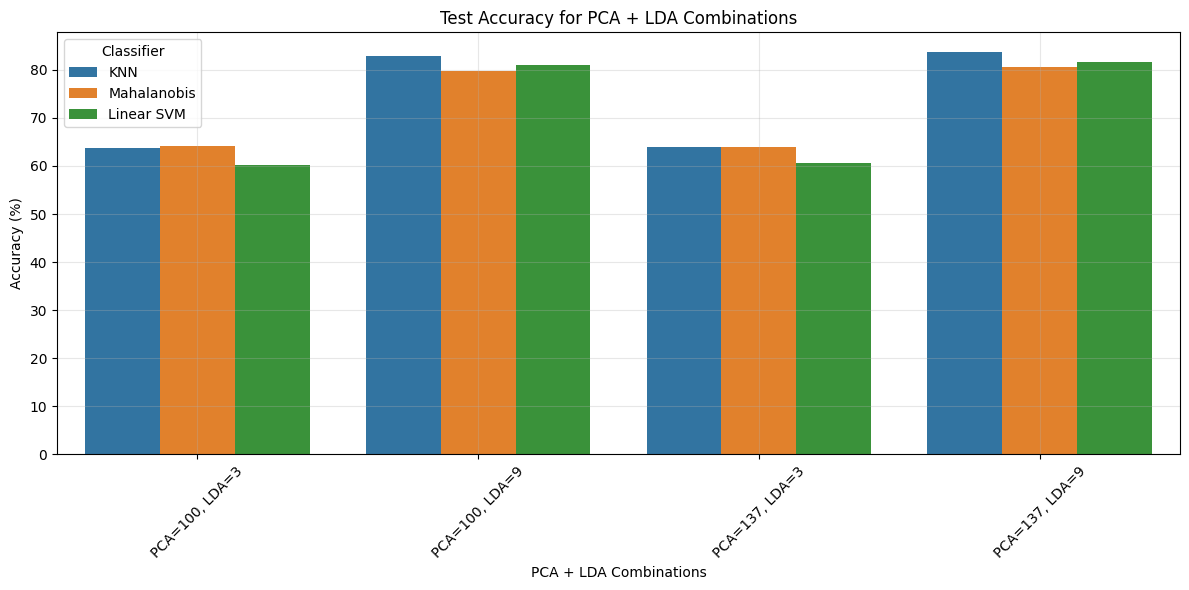

In [ ]:
# 7. Display All Relevant Plots

def plot_pca_scree_and_cumulative(pca):
    """
    Plot the scree plot and cumulative explained variance for PCA.
    """
    explained_variance = pca.explained_variance_
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(12, 6))

    # Scree Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-', label='Eigenvalues')
    plt.axhline(y=1.0, color='gray', linestyle='--', label='Eigenvalue = 1')
    plt.title('Scree Plot (Eigenvalues)')
    plt.xlabel('Principal Components')
    plt.ylabel('Eigenvalue')
    plt.legend()

    # Cumulative Variance
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', label='Cumulative Variance')
    plt.axhline(y=0.9, color='blue', linestyle='--', label='90% Variance Threshold')
    plt.title('Cumulative Variance Explained')
    plt.xlabel('Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_classifier_performance(results, title, x_col='Components'):
    """
    Plot the classifier performance for PCA, LDA, or PCA+LDA.
    """
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results, x=x_col, y='Test Accuracy', hue='Classifier', marker='o')
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel('Accuracy (%)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualize_pca_reconstruction(X_train, pca_components_list):
    """
    Visualize original and reconstructed samples for different PCA components.
    """
    fig, axes = plt.subplots(len(pca_components_list) + 1, 10, figsize=(20, 15))

    # Original samples
    for i in range(10):
        sns.heatmap(X_train[i].reshape(28, 28), ax=axes[0, i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        axes[0, i].set_title(f"Original #{i+1}")

    # Reconstructed samples for each PCA component count
    for row, n_components in enumerate(pca_components_list, start=1):
        pca = PCA(n_components=n_components)
        X_reconstructed = pca.inverse_transform(pca.fit_transform(X_train))

        for i in range(10):
            sns.heatmap(X_reconstructed[i].reshape(28, 28), ax=axes[row, i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
            axes[row, i].set_title(f"{n_components} Comp #{i+1}")

    plt.suptitle('Reconstruction Comparison: Original vs PCA Reduced', fontsize=16)
    plt.tight_layout()
    plt.show()


def visualize_lda_components(results, components):
    """
    Visualize classifier performance for LDA components.
    """
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=results, x='Components', y='Test Accuracy', hue='Classifier', marker='o')
    plt.title('Test Accuracy by LDA Components')
    plt.xlabel('Number of LDA Components')
    plt.ylabel('Accuracy (%)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualize_pca_lda_results(pca_lda_results):
    """
    Visualize PCA + LDA performance with classifiers.
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(data=pca_lda_results, x='Components', y='Test Accuracy', hue='Classifier')
    plt.title('Test Accuracy for PCA + LDA Combinations')
    plt.xlabel('PCA + LDA Combinations')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



pca = PCA()
pca.fit(X_train_scaled)
plot_pca_scree_and_cumulative(pca)

# PCA Classifier Performance
plot_classifier_performance(pca_results, 'PCA Classifier Performance by Components')

# PCA Reconstruction Visualization
visualize_pca_reconstruction(X_train_scaled, [2, 50, 137, 784])

# LDA Classifier Performance
plot_classifier_performance(lda_results, 'LDA Classifier Performance by Components', x_col='Components')

# PCA + LDA Classifier Performance
visualize_pca_lda_results(pca_lda_results)
